In [8]:
import torch
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm import tqdm
from modules.losses import ContrastiveLoss,TripletLoss,SupConLoss,SNRLoss,CentroidTripletLoss
from modules.backbones import ResNet50
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/losses"

In this Notebook we want to compare different contrastive Losses

In [9]:
# we use the entire tiny-imagenet-200 dataset
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    )
len(dataset)

100000

In [10]:
#Build the DataLoaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256,pin_memory=True)

In [11]:
#Train the Models
Epochs = 5
losses = [ContrastiveLoss,TripletLoss,SupConLoss,SNRLoss]
for loss_definition in losses: 
    loss = loss_definition()
    siamese_model = ContrastiveNetwork(ResNet50(pretrained=True,freeze=False),loss)
    
    model_dir = os.path.join(SAVE_DIR,type(loss).__name__)
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    
    #precision = "bf16" if torch.cuda.is_bf16_supported() else 32
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"
    amp_backend="apex"
    amp_level='O1'
    
    trainer = pl.Trainer(accelerator=accelerator, max_epochs=Epochs,amp_backend=amp_backend,amp_level=amp_level,benchmark=True,checkpoint_callback=False,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()

In [12]:
from modules.knn import KNN

knns = {}

for loss_definition in losses: 
    model:torch.nn.Module = ResNet50()
    loss = loss_definition()
    loss_name = type(loss).__name__
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,loss_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[loss_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,loss_name))

In [13]:
results = {}

for loss_definition in losses: 
    model:torch.nn.Module = ResNet50()
    loss = loss_definition()
    loss_name = type(loss).__name__
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,loss_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,loss_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[loss_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))

SNRLoss: 100%|██████████| 79/79 [00:02<00:00, 30.06it/s]


In [14]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

ContrastiveLoss F1-Score: 0.644
TripletLoss F1-Score: 0.606
SupConLoss F1-Score: 0.659
SNRLoss F1-Score: 0.647


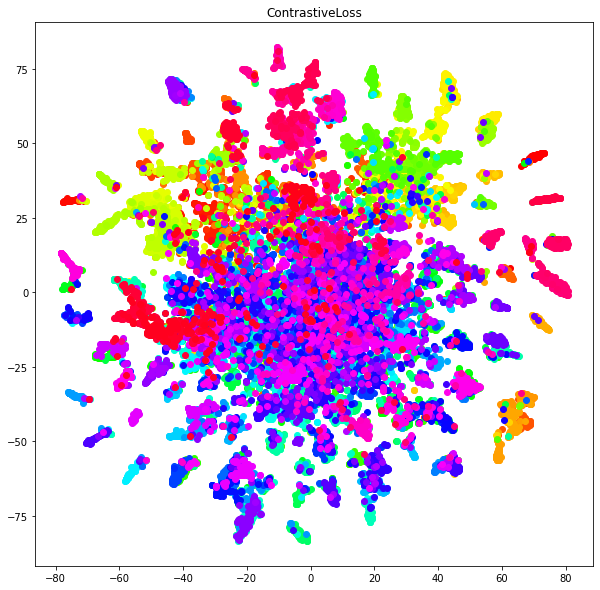

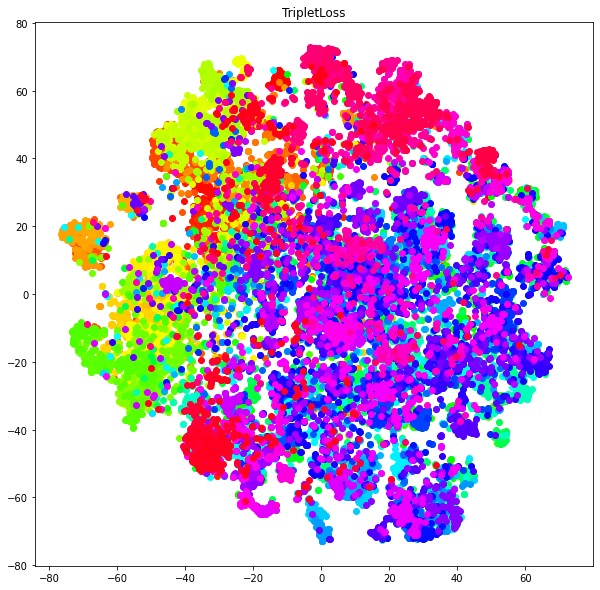

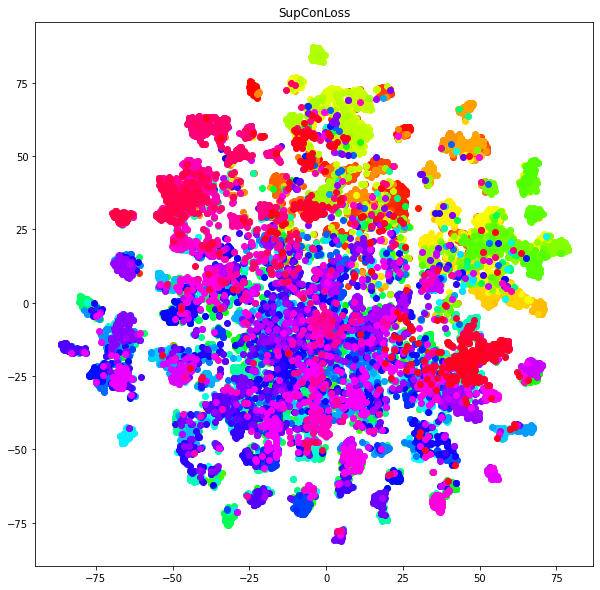

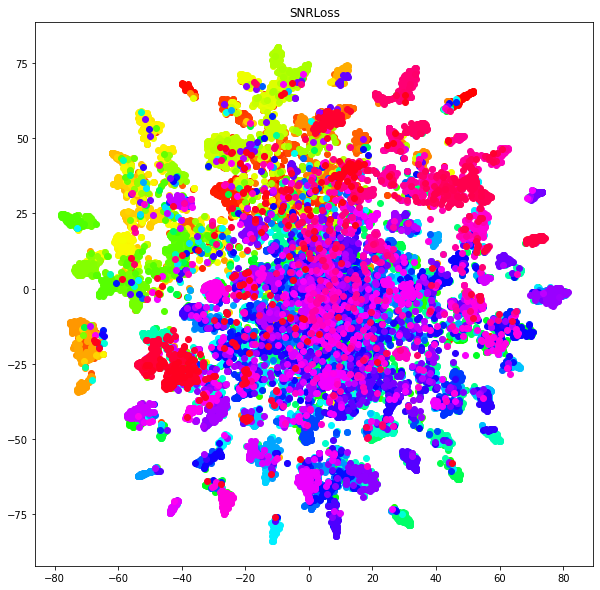

In [15]:
import matplotlib.pyplot as plt
from modules.plotting import plot_tsne

for key in results:
    embeddings,labels = results[key]
    plt.figure(figsize=(10,10))
    
    plot_tsne(embeddings,labels,200)
    plt.title(key)
    plt.show()